Import Of The Important Libraries Required for Solving This Problem.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string 
import re
from nltk.corpus import stopwords
from collections import Counter
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import graphviz
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Dropout
from keras.models import load_model

Using TensorFlow backend.


In [2]:
os.listdir()

['Capstone_project-Sentiment_Analysis.doc',
 'model.png',
 'ncnn_model.png',
 '.~pstone_project-Sentiment_Analysis.doc',
 'ncnn_model.h5',
 '.ipynb_checkpoints',
 'Capstone_proposal.pdf',
 '109311bb0361f32d87a2-8254b53ab8dcb18afc64287aaddd9e5b6059f880',
 'negative.txt',
 '1_5XuZ_86Rfce3qyLt7XMlhw.png',
 'mlp.ipynb',
 'README.md',
 'Sentiment_Analysis_Udacity.ipynb',
 'txt_sentoken',
 'Capstone_project-Sentiment_Analysis.pdf',
 'vocab.txt',
 'rp.tar.gz',
 'review_polarity',
 'positive.txt',
 'cnn_model.png',
 '1-s2.0-S2090447914000550-gr2.jpg',
 'cnn']

# Preprocessing Step 
# Import Data

In [9]:
# Function to load document into the notebook
def load_document(fileName):
    file=open(fileName,'r')
    text_data=file.read()
    file.close()
    return text_data

In [10]:
# Data Cleaning Step
# Turn a document into tokens after processing it.

def clean_document(document,m_type="mlp"):
    document=document.lower()
    #split the review into tokens by white space
    tokens=document.split()
    # regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # removetokens which are not alphabetis
    if m_type=="mlp":
        tokens = [word for word in tokens if word.isalpha()]
        # remove stop words
        ##  A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]
        # remove out short tokens
        tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

In [11]:
filename="txt_sentoken/pos/cv001_18431.txt"
text=load_document(filename)
tokens=clean_document(text)
print(tokens)

['every', 'movie', 'comes', 'along', 'suspect', 'studio', 'every', 'indication', 'stinker', 'everybodys', 'surprise', 'perhaps', 'even', 'studio', 'film', 'becomes', 'critical', 'darling', 'mtv', 'films', 'election', 'high', 'school', 'comedy', 'starring', 'matthew', 'broderick', 'reese', 'witherspoon', 'current', 'example', 'anybody', 'know', 'film', 'existed', 'week', 'opened', 'plot', 'deceptively', 'simple', 'george', 'washington', 'carver', 'high', 'school', 'student', 'elections', 'tracy', 'flick', 'reese', 'witherspoon', 'overachiever', 'hand', 'raised', 'nearly', 'every', 'question', 'way', 'way', 'high', 'mr', 'matthew', 'broderick', 'sick', 'megalomaniac', 'student', 'encourages', 'paul', 'popularbutslow', 'jock', 'run', 'pauls', 'nihilistic', 'sister', 'jumps', 'race', 'well', 'personal', 'reasons', 'dark', 'side', 'sleeper', 'success', 'expectations', 'low', 'going', 'fact', 'quality', 'stuff', 'made', 'reviews', 'even', 'enthusiastic', 'right', 'cant', 'help', 'going', 'ba

In [12]:
# Function to save list to file
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [13]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [14]:
# directory='txt_sentoken/neg'
# for file in os.listdir(directory):
#     if file.endswith(".txt"):
#         doc=load_document(directory+'/'+file)
#         print("Loaded Document %s" % file)

# Develop Vocabulary

In [15]:
# Function to Load Document and then add the words to Vocab
def document_to_vocabulary(fileName,vocab):
    document=load_document(fileName)
    tokens=clean_document(document)
    vocab.update(tokens)

In [16]:
# Function to Process All the documents in the Directory
def process_documents(directory, vocab):
    count=0
    for fileName in os.listdir(directory):
        if fileName.endswith(".txt"):
            path=directory+"/"+fileName
            document_to_vocabulary(path,vocab)
            count+=1
    print("Total Number Of Files Processed In {d} = {n}".format(d=directory,n=count))

In [17]:
# Main Function To Process the documents 
# Global Varaible To Store The Count 

vocab = Counter()

def develop_vocab():
    global vocab
#     vocab= Counter()
    process_documents('txt_sentoken/neg', vocab)
    process_documents('txt_sentoken/pos', vocab)
    
    
    min_occur = 5
    
    tokens = [k for k,c in vocab.items() if c >= min_occur]
    save_list(tokens,"vocab.txt")

develop_vocab()

Total Number Of Files Processed In txt_sentoken/neg = 1000
Total Number Of Files Processed In txt_sentoken/pos = 1000


In [18]:
#Check Whether The File is Create or not 
if "vocab.txt" in os.listdir():
    print("TRUE")

TRUE


In [19]:
#print Length of the Vocabulary
print("Total Length Of The Vocabulary %s" %len(vocab))

Total Length Of The Vocabulary 46557


In [20]:
# 50 Most Common Words
print(vocab.most_common(50))

[('film', 8860), ('one', 5521), ('movie', 5440), ('like', 3553), ('even', 2555), ('good', 2320), ('time', 2283), ('story', 2118), ('films', 2102), ('would', 2042), ('much', 2024), ('also', 1965), ('characters', 1947), ('get', 1921), ('character', 1906), ('two', 1825), ('first', 1768), ('see', 1730), ('well', 1694), ('way', 1668), ('make', 1590), ('really', 1563), ('little', 1491), ('life', 1472), ('plot', 1451), ('people', 1420), ('movies', 1416), ('could', 1395), ('bad', 1374), ('scene', 1373), ('never', 1364), ('best', 1301), ('new', 1277), ('many', 1268), ('doesnt', 1267), ('man', 1266), ('scenes', 1265), ('dont', 1210), ('know', 1207), ('hes', 1150), ('great', 1141), ('another', 1111), ('love', 1089), ('action', 1078), ('go', 1075), ('us', 1065), ('director', 1056), ('something', 1048), ('end', 1047), ('still', 1038)]


# Top Ten Most Common Words

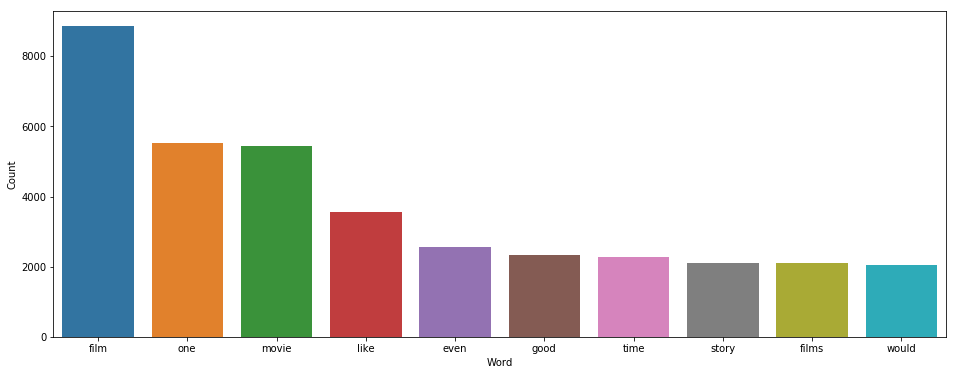

In [21]:
vocabmcdf=pd.DataFrame(data=vocab.most_common(10),columns=['Word','Count'])
plt.figure(figsize=(16,6))
sns.barplot(x='Word',y="Count",data=vocabmcdf)

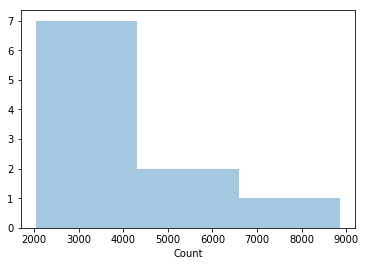

In [30]:
sns.distplot(vocabmcdf['Count'],kde = False)
plt.show()

In [97]:
#Load The Vocabulary from Vocab.txt File.

vocab_data=load_document("vocab.txt")
vocab_data=vocab_data.split()
vocab=set(vocab_data)
print("Number of Words in Vocab.txt is %s" %len(vocab))

Number of Words in Vocab.txt is 14803


# The distribution review text lengths

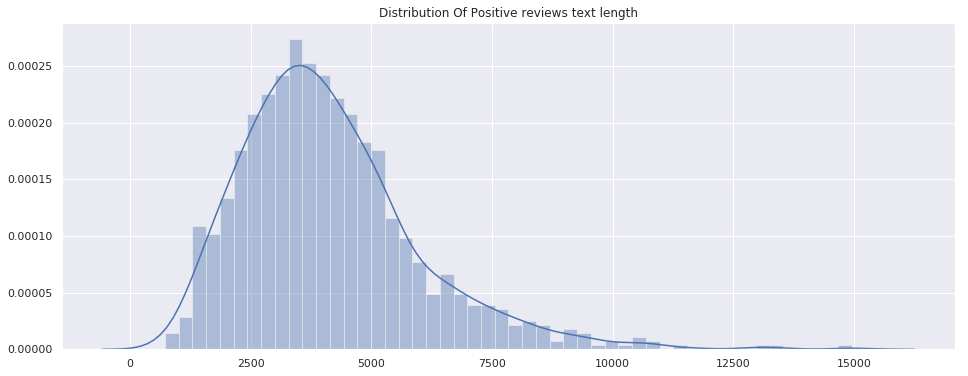

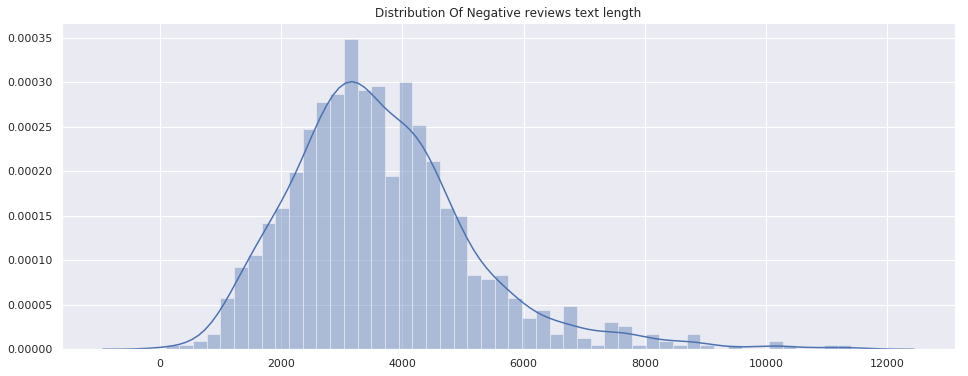

In [71]:
sns.set(color_codes=True)
plt.figure(figsize=(16,6))
p_f="txt_sentoken/pos"
prl=[]
for f in sorted(os.listdir(p_f)):
#     print(f)
    l=len(load_document(p_f+"/"+f))
    prl.append(l)
sns.distplot(prl,bins=50).set_title("Distribution Of Positive reviews text length")
plt.show()
n_f="txt_sentoken/neg"
nrl=[]
for f in sorted(os.listdir(n_f)):
    l=len(load_document(n_f+"/"+f))
    nrl.append(l)
plt.figure(figsize=(16,6))
sns.distplot(nrl,bins=50).set_title("Distribution Of Negative reviews text length")
plt.show()

# The distribution of review word count After Cleaning Reviews

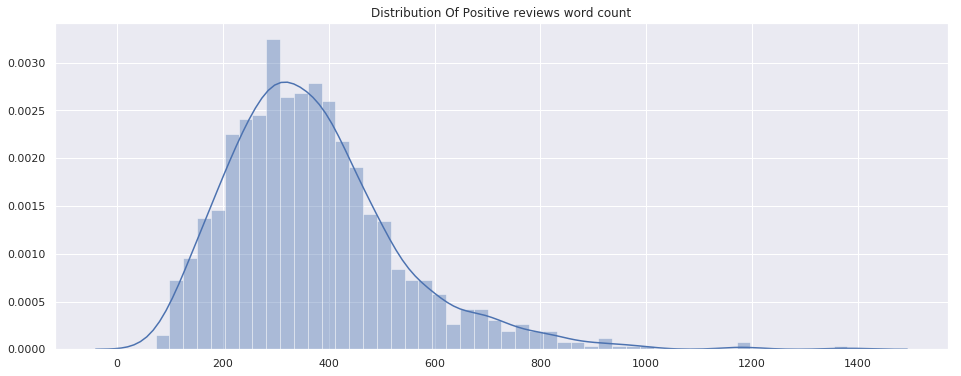

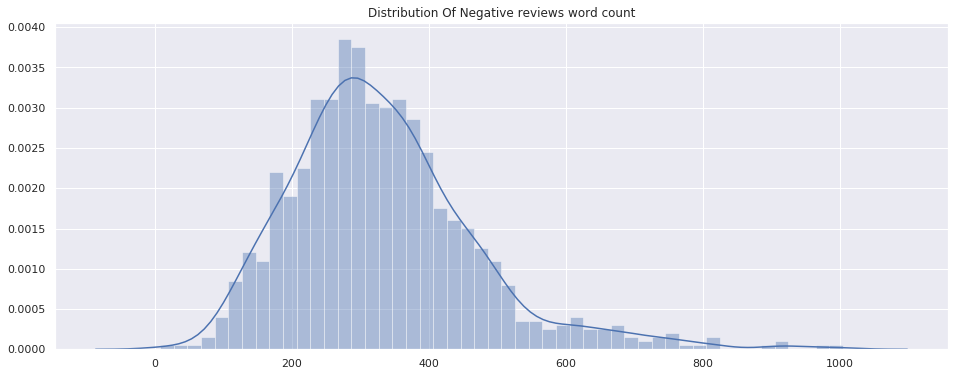

In [65]:
sns.set(color_codes=True)
plt.figure(figsize=(16,6))
p_f="txt_sentoken/pos"
prl=[]
for f in sorted(os.listdir(p_f)):
#     print(f)
    text=load_document(p_f+"/"+f)
    tokens=clean_document(text)
    l=len(tokens)
    prl.append(l)
sns.distplot(prl,bins=50).set_title("Distribution Of Positive reviews word count")
plt.show()
n_f="txt_sentoken/neg"
nrl=[]
for f in sorted(os.listdir(n_f)):
    text=load_document(n_f+"/"+f)
    tokens=clean_document(text)
    l=len(tokens)
    nrl.append(l)
plt.figure(figsize=(16,6))
sns.distplot(nrl,bins=50).set_title("Distribution Of Negative reviews word count")
plt.show()

# Prepare Review For Modeling

Creating Negative.txt and Positive.txt from all the review documents.

In [103]:
def process_review_documents(directory,vocab,train=False,op=0,m_type="mlp"):
    lines=[]
    count=0
    for file in os.listdir(directory):
#         print(file)
        if file.endswith(".txt"):
            if not op:
                if train and file.startswith("cv9"):
                    continue
                if not train and not file.startswith("cv9"):
                    continue
            count=count+1
            file_path=directory + '/' + file
            lines_in_file=load_document(file_path)
            tokens=clean_document(lines_in_file,m_type)
            tokens=[w for w in tokens if w in vocab]
            line=' '.join(tokens)
        lines.append(line)
#         print(lines)
    print("Number of File Processed in {d} is {n}".format(d=directory,n=count))
    return lines

# Negative lines from all the documents from "txt_sentoken/neg"

In [104]:
# Negative lines from all the documents from "txt_sentoken/neg"
neg_lines=process_review_documents("txt_sentoken/neg",vocab_data,op=1)
save_list(neg_lines,"negative.txt")

#Load Negative Lines From negative.txt
negative_lines=load_document("negative.txt")
print("Length of the Negative.txt File is %s " %len(negative_lines))


Number of File Processed in txt_sentoken/neg is 1000
Length of the Negative.txt File is 2124581 


In [105]:
print(negative_lines[:100])

studio attracted many weird bizarre people gates wonder film life death studio centers one boring cl


# Positive lines from all the documents from "txt_sentoken/pos"

In [106]:
# Negative lines from all the documents from "txt_sentoken/neg"
pos_lines=process_review_documents("txt_sentoken/pos",vocab_data,op=1)
save_list(pos_lines,"positive.txt")

#Load Negative Lines From negative.txr
positive_lines=load_document("positive.txt")
print("Length of the Positive.txt File is %s " %len(positive_lines))


Number of File Processed in txt_sentoken/pos is 1000
Length of the Positive.txt File is 2408780 


In [108]:
print(positive_lines[:100])

david lynchs blue velvet begins ends colorful bright shots flowers happy americans seemingly perfect


In [109]:
def load_clean_dataset(vocab,op,train=False,m_type="mlp"):
    neg=process_review_documents('txt_sentoken/neg', vocab,train,op,m_type)
    pos=process_review_documents('txt_sentoken/pos', vocab,train,op,m_type)
    docs=neg+pos
    print("Length of   Negative Files = {n} \t Positive Files= {p} \t Doc = {d} ".format(n=len(neg),p=len(pos),d=len(docs)))
    labels =[0 for i in range(len(neg))] + [1 for j in range(len(pos))]
    return docs,labels
    

# Train Test Split

Dividing 90% 10% Ration 1000 Review Document

# Load Training DataSet

In [110]:
# load all training reviews
train_docs, ytrain = load_clean_dataset(vocab,train=True,op=0)


Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 


In [111]:
print(len(train_docs))

1800


In [112]:
print(len(ytrain))

1800


# Load Test DataSet

In [113]:
test_docs, ytest = load_clean_dataset(vocab,train=False,op=0)

Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


# Keras Tokenizer To Implement Bag Of Words

In [114]:
# Function To Tokenize
def create_tokenizer(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [115]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [116]:
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

(1800, 14781) (200, 14781)


# Benchmark Model

In [117]:
n_words=Xtest.shape[1]
n_words

14781

In [309]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(25, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [310]:
#fit network
model=define_model(n_words)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 25)                369550    
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 26        
Total params: 369,576
Trainable params: 369,576
Non-trainable params: 0
_________________________________________________________________


In [311]:
model.fit(Xtrain, ytrain, epochs=10, verbose=1)


Epoch 1/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6917 - acc: 0.5989
Epoch 2/10
1800/1800 [==============================] - 1s 412us/step - loss: 0.6841 - acc: 0.8711
Epoch 3/10
1800/1800 [==============================] - 1s 371us/step - loss: 0.6721 - acc: 0.8572
Epoch 4/10
1800/1800 [==============================] - 1s 394us/step - loss: 0.6549 - acc: 0.8611
Epoch 5/10
1800/1800 [==============================] - 1s 403us/step - loss: 0.6323 - acc: 0.9206
Epoch 6/10
1800/1800 [==============================] - 1s 395us/step - loss: 0.6056 - acc: 0.9233
Epoch 7/10
1800/1800 [==============================] - 1s 402us/step - loss: 0.5766 - acc: 0.9256
Epoch 8/10
1800/1800 [==============================] - 1s 395us/step - loss: 0.5449 - acc: 0.9356
Epoch 9/10
1800/1800 [==============================] - 1s 392us/step - loss: 0.5129 - acc: 0.9400
Epoch 10/10
1800/1800 [==============================] - 1s 405us/step - loss: 0.4814 - acc: 0.9433


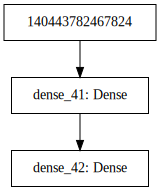

In [312]:
#Plot of The Defined model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [313]:
# evaluate
loss, acc  = model.evaluate(Xtest, ytest, verbose=0)
print('Test Loss: %f' % (loss*100))
print('Test Accuracy: %f' % (acc*100))

Test Loss: 54.455891
Test Accuracy: 86.000000


# Predicting Sentiment For Reviews For Benchmark Model.


In [316]:
def predict_sentiment(review, vocab, tokenizer, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    print(line)
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    yhat = model.predict(encoded, verbose=0)
    percent_pos = yhat[0,0]
#     if percent_pos < 0.5:
#         return (1-percent_pos), 'NEGATIVE'
#     else:
#             if percent_pos >0.5 and percent_pos<0.505:
#                 return percent_pos, 'NEUTRAL'
#             else:
#                 return percent_pos, 'POSITIVE'
    if percent_pos < 0.49:
        return (1-percent_pos), 'NEGATIVE'
    else:
#         if percent_pos >0.5 and percent_pos<0.5045:
#             return percent_pos, 'NEUTRAL'
#         else:
        return percent_pos, 'POSITIVE'
#     if round(percent_pos)==0:
#         return (1-percent_pos), 'NEGATIVE'
#     return percent_pos, 'POSITIVE'

In [317]:
#
# MLP
#
m_type="mlp"

text = 'It is an ok movie one time watch'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
# test negative text

text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'An above average one for one time watch.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))


text = 'Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters \
I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just \
cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.\
However, I feel that the sequel might be better because they dont have to build up the character so much..'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'Spiderman was just ok. Its not the greatest comic book movie. I still prefer the original Batman movie, Superman and The Daredevil movie. Spiderman had a few cool scenes \
but overall I was disappointed. Tobey was pretty good. Kirsten, uhh, liked her in Virgin Suicide, \
wasnt digging her in this role. Fell flat in my opinion.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

ok movie one time watch
Review: [It is an ok movie one time watch]
Sentiment: NEGATIVE (70.844%) 

best movie ever great recommend
Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (82.057%) 

bad movie
Review: [This is a bad movie.]
Sentiment: NEGATIVE (99.110%) 

average one one time watch
Review: [An above average one for one time watch.]
Sentiment: POSITIVE (51.494%) 

give break top movie time even close bad guy movie one worst characters ever seen good flick tried build love peter parker girl sudden cant please movie become cult movie get good rating people afraid speak truth movie wasnt feel sequel might better dont build character much
Review: [Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just cant be with her? Please. This movie will become 

# CNN with Embedding Layer Model

I will test different options to see which gives the best result on this problem .

CNN With Embedding Layer

In [130]:
#Load Train And test Set for Embedding 

cnn_train_docs, ytrain = load_clean_dataset(vocab, train=True,op=0,m_type="cnn")
cnn_test_docs, ytest = load_clean_dataset(vocab,train=False,op=0,m_type="cnn")

Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 
Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


In [131]:
max_length = max([len(s.split()) for s in cnn_train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1244


In [132]:
def encode_documents(tokenizer ,max_length,docs):
    encoded=tokenizer.texts_to_sequences(docs)
    padded=pad_sequences(encoded,maxlen=max_length,padding='post')
    return padded

In [133]:
def define_embed_cnn_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     filepath="weights.best.hdf5"
#     checkpoint = ModelCheckpoint(filepath, monitor= 'val_acc' , verbose=1, save_best_only=True,
#     mode= max )
#     callbacks_list = [checkpoint]
    # summarize defined model
    model.summary()
    plot_model(model, to_file='cnn_model.png', show_shapes=True)
#     return model,callbacks_list
    return model

In [134]:
cnn_tokenizer=create_tokenizer(cnn_train_docs)
vocabulary_size=len(cnn_tokenizer.word_index)+1
print("Vocabulary Size %d"%vocabulary_size)

Vocabulary Size 14781


In [138]:
# def predict_sentiment(review, vocab, tokenizer,max_length, model):
#     tokens = clean_document(review)
#     tokens = [w for w in tokens if w in vocab]
#     line = ' '.join(tokens)
#     padded=encode_documents(tokenizer,max_length,[line])
#     # predict sentiment
#     yhat = model.predict(padded, verbose=0)
#     percent_pos = yhat[0,0]
#     print(percent_pos)
#     if percent_pos < 0.49:
#         return (1-percent_pos), 'NEGATIVE'
#     else:
#         if percent_pos >0.5 and percent_pos<0.5045:
#             return percent_pos, 'NEUTRAL'
#         else:
#             return percent_pos, 'POSITIVE'

In [139]:
cnn_Xtrain = encode_documents(cnn_tokenizer, max_length, cnn_train_docs)
cnn_Xtest = encode_documents(cnn_tokenizer, max_length, cnn_test_docs)

print(len(cnn_Xtrain))
print(len(cnn_Xtest))

1800
200


In [136]:
embed_cnn_model=define_embed_cnn_model(vocabulary_size,max_length)

# embed_cnn_model,callb=define_embed_cnn_model(vocabulary_size,max_length)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1244, 100)         1478100   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1237, 32)          25632     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 618, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 19776)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                197770    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 1,701,513
Trainable params: 1,701,513
Non-trainable params: 0
_________________________________________________________________


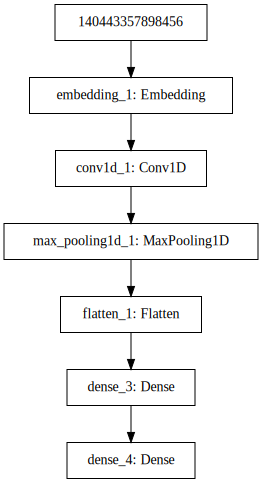

In [45]:
#Plot of The Defined model
SVG(model_to_dot(embed_cnn_model).create(prog='dot', format='svg'))

In [137]:
embed_cnn_model.fit(cnn_Xtrain, ytrain, epochs=10, verbose=1)

# history=embed_cnn_model.fit(cnn_Xtrain, ytrain,validation_split=0.20 ,epochs=10, verbose=0,batch_size=100,callbacks=callb)

Epoch 1/10
1800/1800 [==============================] - 13s 7ms/step - loss: 0.6900 - acc: 0.5378
Epoch 2/10
1800/1800 [==============================] - 18s 10ms/step - loss: 0.5349 - acc: 0.7561
Epoch 3/10
1800/1800 [==============================] - 15s 8ms/step - loss: 0.1252 - acc: 0.9578
Epoch 4/10
1800/1800 [==============================] - 14s 8ms/step - loss: 0.0145 - acc: 0.9989
Epoch 5/10
1800/1800 [==============================] - 13s 7ms/step - loss: 0.0033 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 12s 7ms/step - loss: 0.0017 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 16s 9ms/step - loss: 0.0012 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 13s 7ms/step - loss: 9.2583e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 13s 7ms/step - loss: 7.4423e-04 - acc: 1.0000
Epoch 10/10
1800/1800 [==============================] - 18s 10ms/step - loss: 6.2321e-04 - acc: 1.0000


# History Of Accuracy And Loss

In [47]:
# 
# print(h`istory.history.keys())

# # history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['loss'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# # history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Evaluate Cnn Model 

In [141]:
# evaluate Train Accuracy and Loss
cnn_loss, cnn_acc  = embed_cnn_model.evaluate(cnn_Xtrain, ytrain, verbose=1)
print('Train Loss: %f' % (cnn_loss*100))
print('Train Accuracy: %f\n' % (cnn_acc*100))

# evaluate Test Accuracy and Loss
cnn_loss, cnn_acc  = embed_cnn_model.evaluate(cnn_Xtest, ytest, verbose=1)
print('Test Loss: %f' % (cnn_loss*100))
print('Test Accuracy: %f' % (cnn_acc*100))

1800/1800 [==============================] - 4s 2ms/step
Train Loss: 0.055193
Train Accuracy: 100.000000

200/200 [==============================] - 1s 3ms/step
Test Loss: 49.719241
Test Accuracy: 86.500000


Save Model

In [49]:
# model.save('embedd_cnn_model.h5')

In [212]:
def predict_cnn_sentiment(review, vocab, tokenizer,max_length, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    print(line)
    padded=encode_documents(tokenizer,max_length,[line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    percent_pos = yhat[0,0]
    print(percent_pos)
#     if percent_pos < 0.49:
#         return (1-percent_pos), 'NEGATIVE'
#     else:
#         if percent_pos >0.5 and percent_pos<0.5045:
#             return percent_pos, 'NEUTRAL'
#         else:
#             return percent_pos, 'POSITIVE'
    if percent_pos < 0.49:
        return (1-percent_pos), 'NEGATIVE'
    else:
#         if percent_pos >0.5 and percent_pos<0.5045:
#             return percent_pos, 'NEUTRAL'
#         else:
        return percent_pos, 'POSITIVE'
#     if round(percent_pos)==0:
#         return (1-percent_pos), 'NEGATIVE'
#     return percent_pos, 'POSITIVE'

In [143]:
# def predict_sentiment(review, vocab, tokenizer,max_length, model):
#     tokens = clean_document(review)
#     tokens = [w for w in tokens if w in vocab]
#     line = ' '.join(tokens)
#     padded=encode_documents(tokenizer,max_length,[line])
#     # predict sentiment
#     yhat = model.predict(padded, verbose=0)
#     percent_pos = yhat[0,0]
#     print(percent_pos)
#     if round(percent_pos) == 0:
#         return (1-percent_pos), 'NEGATIVE'
#     return percent_pos, 'POSITIVE'

In [144]:
# embed_cnn_model.load_weights("weights.best.hdf5")
# embed_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [213]:
text = 'It is an ok movie one time watch'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n ' % (text, sentiment, percent*100))

text = 'Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters \
I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just \
cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.\
However, I feel that the sequel might be better because they dont have to build up the character so much..'

percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'Spiderman was just ok. Its not the greatest comic book movie. I still prefer the original Batman movie, Superman and The Daredevil movie. Spiderman had a few cool scenes \
but overall I was disappointed. Tobey was pretty good. Kirsten, uhh, liked her in Virgin Suicide, \
wasnt digging her in this role. Fell flat in my opinion.'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = "The goodness of the  story ever told on film . I would recommend this movie to everyone ."
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'An above average one for one time watch.'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

ok movie one time watch
0.5109663
Review: [It is an ok movie one time watch]
Sentiment: POSITIVE (51.097%) 

bad movie watch sucks
0.4449024
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (55.510%) 
 
give break top movie time even close bad guy movie one worst characters ever seen good flick tried build love peter parker girl sudden cant please movie become cult movie get good rating people afraid speak truth movie wasnt feel sequel might better dont build character much
0.18961701
Review: [Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.However, I feel that the sequel mi

In [214]:
text = 'Everyone will enjoy this film. I love it, recommended!'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = "Very heart touching and making us proud movie. The acting done \
by akshay Kumar is awesome in the movie.   \
The whole theater was emotional at the end of the movie . I would recommend this movie to everyone."

percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n'  % (text, sentiment, percent*100))

text = 'I loved This Movie. This Movie is too good ,I would recommend this movie to everyone.'
percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

everyone enjoy film love recommended
0.513243
Review: [Everyone will enjoy this film. I love it, recommended!]
Sentiment: POSITIVE (51.324%) 

bad movie watch sucks
0.4449024
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (55.510%) 

heart touching making us proud movie acting done awesome movie whole theater emotional end movie would recommend movie everyone
0.28799298
Review: [Very heart touching and making us proud movie. The acting done by akshay Kumar is awesome in the movie.   The whole theater was emotional at the end of the movie . I would recommend this movie to everyone.]
Sentiment: NEGATIVE (71.201%) 

loved movie movie good would recommend movie everyone
0.50684905
Review: [I loved This Movie. This Movie is too good ,I would recommend this movie to everyone.]
Sentiment: POSITIVE (50.685%) 



# N-Gram Embedding Cnn Model.

In [284]:
#Load Train And test Set for Embedding 

ncnn_train_docs, ytrain = load_clean_dataset(vocab, train=True,op=0,m_type="ncnn")
ncnn_test_docs, ytest = load_clean_dataset(vocab,train=False,op=0,m_type="ncnn")


Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 
Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


In [285]:
ncnn_tokenizer = create_tokenizer(ncnn_train_docs)

In [286]:
length = max([len(s.split()) for s in ncnn_train_docs])
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(ncnn_tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Max document length: 1244
Vocabulary size: 14781


In [287]:
ncnn_Xtrain = encode_documents(ncnn_tokenizer,length, ncnn_train_docs)
ncnn_Xtest = encode_documents(ncnn_tokenizer, length,ncnn_test_docs)

In [288]:
print(ncnn_Xtrain.shape)
print(ncnn_Xtest.shape)

(1800, 1244)
(200, 1244)


In [302]:
def define_ncnn_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
#     # channel 3
#     inputs4 = Input(shape=(length,))
#     embedding4 = Embedding(vocab_size, 100)(inputs4)
#     conv4 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling1D(pool_size=2)(drop4)
#     flat4 = Flatten()(pool4)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    model.summary()
    plot_model(model, show_shapes=True, to_file='ncnn_model.png')
    return model

In [303]:
ncnn_model= define_ncnn_model(length, vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 1244)         0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 1244)         0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 1244)         0                                            
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, 1244, 100)    1478100     input_44[0][0]                   
__________________________________________________________________________________________________
embedding_

In [304]:
# print(ncnn_Xtrain.shape)
# print(ncnn_Xtest.shape)

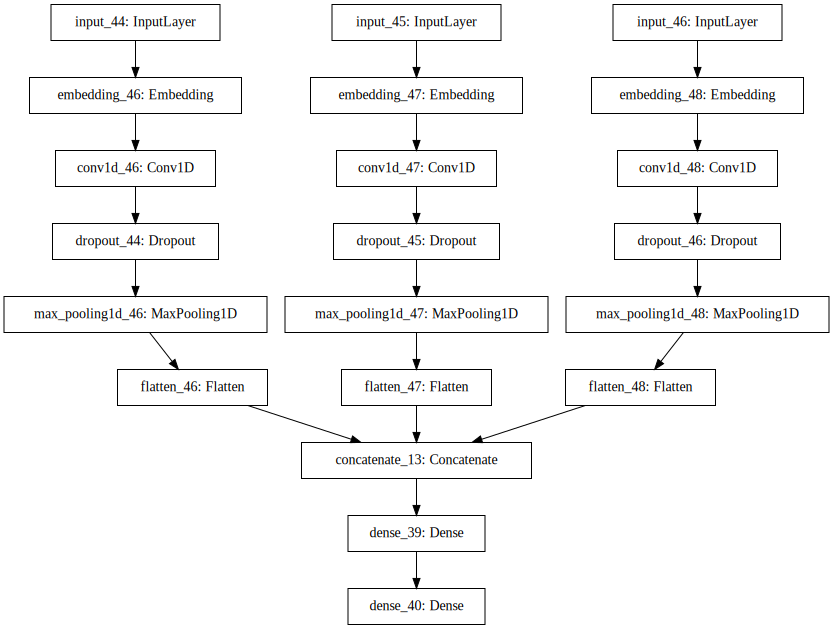

In [305]:
#Plot of The Defined model
SVG(model_to_dot(ncnn_model).create(prog='dot', format='svg'))

In [306]:
ncnn_model.fit( [ncnn_Xtrain,ncnn_Xtrain,ncnn_Xtrain] , ytrain, epochs=8, batch_size=16)

Epoch 1/8
1800/1800 [==============================] - 42s 24ms/step - loss: 0.6921 - acc: 0.5222
Epoch 2/8
1800/1800 [==============================] - 40s 22ms/step - loss: 0.5597 - acc: 0.7372
Epoch 3/8
1800/1800 [==============================] - 36s 20ms/step - loss: 0.0993 - acc: 0.9689
Epoch 4/8
1800/1800 [==============================] - 35s 20ms/step - loss: 0.0072 - acc: 0.9994
Epoch 5/8
1800/1800 [==============================] - 37s 21ms/step - loss: 0.0018 - acc: 1.0000
Epoch 6/8
1800/1800 [==============================] - 40s 22ms/step - loss: 0.0010 - acc: 1.0000
Epoch 7/8
1800/1800 [==============================] - 39s 21ms/step - loss: 6.8773e-04 - acc: 1.0000
Epoch 8/8
1800/1800 [==============================] - 41s 23ms/step - loss: 4.9651e-04 - acc: 1.0000


In [276]:
# ncnn_model.save('ncnn_model.h5')

In [182]:
# ncnn_Xtrain.shape

In [183]:
# ncnn_Xtest.shape

In [184]:
# ncnn_Xtrain=np.array(ncnn_Xtrain)


In [307]:
# evaluate model on training dataset
loss, acc = ncnn_model.evaluate([ncnn_Xtrain,ncnn_Xtrain,ncnn_Xtrain], ytrain, verbose=1)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset dataset
loss, acc = ncnn_model.evaluate([ncnn_Xtest,ncnn_Xtest,ncnn_Xtest], ytest, verbose=1)
print('Test Accuracy: %.2f' % (acc*100))

1800/1800 [==============================] - 10s 5ms/step
Train Accuracy: 100.00
200/200 [==============================] - 1s 5ms/step
Test Accuracy: 87.00


In [297]:
def predict_ncnn_sentiment(review, vocab, tokenizer,max_length, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    print(line)
    padded=encode_documents(tokenizer,max_length,[line])
    # predict sentiment
    yhat = model.predict([padded,padded,padded], verbose=0)
    percent_pos = yhat[0,0]
    print(percent_pos)
    if percent_pos < 0.49:
        return (1-percent_pos), 'NEGATIVE'
    else:
#         if percent_pos >0.5 and percent_pos<0.5045:
#             return percent_pos, 'NEUTRAL'
#         else:
        return percent_pos, 'POSITIVE'
#     if round(percent_pos)==0:
#         return (1-percent_pos), 'NEGATIVE'
#     return percent_pos, 'POSITIVE'

In [298]:
text = 'It is an ok movie one time watch'
percent, sentiment = predict_ncnn_sentiment(text, vocab, ncnn_tokenizer, length, ncnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'I loved This Movie.I would recommend this movie to everyone.I loved This Movie. GoodNess Goodness Goodness I would recommend this movie to everyone.'
percent, sentiment =  predict_ncnn_sentiment(text, vocab, ncnn_tokenizer, length, ncnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

text = 'Bad , Bad , Bad I Hate this Movie No One Should waste money watching this'
percent, sentiment =  predict_ncnn_sentiment(text, vocab, ncnn_tokenizer, length, ncnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))

ok movie one time watch
0.5051639
Review: [It is an ok movie one time watch]
Sentiment: POSITIVE (50.516%) 

loved would recommend movie loved movie goodness goodness goodness would recommend movie everyone
0.6596375
Review: [I loved This Movie.I would recommend this movie to everyone.I loved This Movie. GoodNess Goodness Goodness I would recommend this movie to everyone.]
Sentiment: POSITIVE (65.964%) 

bad bad bad hate movie one waste money watching
0.18181247
Review: [Bad , Bad , Bad I Hate this Movie No One Should waste money watching this]
Sentiment: NEGATIVE (81.819%) 



# Test

In [451]:
fn=sorted(os.listdir('txt_sentoken/mtest/pos'))
fn
nf=sorted(os.listdir('txt_sentoken/mtest/neg'))

* Tested using MLP Model

In [452]:

def testFromFolderMLP(vocab,tokenizer,model):
    print("-------------Testing For---MLP-----------------------")
    print("------------Testing For Positive Files---------------")
    pos_list=list()
    neg_list=list()
    filesinfolder=sorted(os.listdir('txt_sentoken/mtest/pos'))
    print(filesinfolder)
    for files in filesinfolder:
        filename="txt_sentoken/mtest/pos/"+files
        print(filename)
        text=load_document(filename)
        percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
#         print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
        print('Sentiment: %s (%.3f%%) \n' % (sentiment, percent*100))
        pos_list.append([sentiment,percent*100])
    print("------------Testing For Negative Files---------------")
    filesinfolder=sorted(os.listdir('txt_sentoken/mtest/neg'))
    print(filesinfolder)
    for files in filesinfolder:
        filename="txt_sentoken/mtest/neg/"+files
        print(filename)
        text=load_document(filename)
        percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
#         print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
        print('Sentiment: %s (%.3f%%) \n' % (sentiment, percent*100))
        neg_list.append([sentiment,percent*100])
    
    print("---------Positive List----------")
#     print(*pos_list)
    pdf = pd.DataFrame(pos_list, columns=['Sentiment','Percent'])
    print(pdf.head(n=10))
    print("---------Negative List----------")
#     print(*neg_list)
    ndf = pd.DataFrame(neg_list,columns=['Sentiment','Percent'])
    print(ndf.head(n=10))
    return pdf , ndf
    
mlppdf,mlpndf=testFromFolderMLP(vocab,tokenizer,model)

-------------Testing For---MLP-----------------------
------------Testing For Positive Files---------------
['pos_file0.txt', 'pos_file1.txt', 'pos_file2.txt', 'pos_file3.txt', 'pos_file4.txt', 'pos_file5.txt', 'pos_file6.txt', 'pos_file7.txt', 'pos_file8.txt', 'pos_file9.txt']
txt_sentoken/mtest/pos/pos_file0.txt
always rate things first written review everyone go watch seriously would death inside enjoy movie funny sad heartwarming enough action superhero movie couple things probably scary kids unless child like daughter didnt think scary twist well unexpected course go watch
Sentiment: NEGATIVE (68.476%) 

txt_sentoken/mtest/pos/pos_file1.txt
stars superhero incarnation average superhero blockbuster teenage foster child philadelphia discovers calling superhero angel solid teenage considerably upstaged jack dylan gives likeable performance aspiring sidekick mark strong menacing human vessel seven deadly sins rousing funny film great entertainment although wonder much medium children 

In [453]:
# mlppdf

In [454]:
# mlpndf

* Tested Using CNN 1 Layer Embedding Model

In [455]:

def testFromFolderCnn(vocab,tokenizer,l,model):
    print("------------Testing For---CNN 1 Layer-----------------------")
    print("------------Testing For Positive Files---------------")
    pos_list=list()
    neg_list=list()
    filesinfolder=sorted(os.listdir('txt_sentoken/mtest/pos'))
    print(filesinfolder)
    for files in filesinfolder:
        filename="txt_sentoken/mtest/pos/"+files
        print("-----------Processing ----------%s"%files)
        text=load_document(filename)
        percent, sentiment = predict_cnn_sentiment(text, vocab, tokenizer, l, model)
#         print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
        print('Sentiment: %s (%.3f%%) \n' % (sentiment, percent*100))
        pos_list.append([sentiment,percent*100])
    print("------------Testing For Negative Files---------------")
    filesinfolder=sorted(os.listdir('txt_sentoken/mtest/neg'))
    print(filesinfolder)
    for files in filesinfolder:
        filename="txt_sentoken/mtest/neg/"+files
        print(filename)
        text=load_document(filename)
        percent, sentiment = predict_cnn_sentiment(text, vocab, tokenizer, l, model)
#         print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
        print('Sentiment: %s (%.3f%%) \n' % (sentiment, percent*100))
        neg_list.append([sentiment,percent*100])
    
    print("---------Positive List----------")
#     print(*pos_list)
    pdf = pd.DataFrame(pos_list,columns=['Analysis','Percent'])
    print(pdf.head(n=10))
    print("---------Negative List----------")
#     print(*neg_list)
    ndf = pd.DataFrame(neg_list,columns=['File Name','Percent'])
    print(ndf.head(n=10))
    
    return pdf,ndf
    
cnnpdf,cnnndf=testFromFolderCnn(vocab,cnn_tokenizer,max_length,embed_cnn_model)


# percent, sentiment = predict_cnn_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
# print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))


------------Testing For---CNN 1 Layer-----------------------
------------Testing For Positive Files---------------
['pos_file0.txt', 'pos_file1.txt', 'pos_file2.txt', 'pos_file3.txt', 'pos_file4.txt', 'pos_file5.txt', 'pos_file6.txt', 'pos_file7.txt', 'pos_file8.txt', 'pos_file9.txt']
-----------Processing ----------pos_file0.txt
always rate things first written review everyone go watch seriously would death inside enjoy movie funny sad heartwarming enough action superhero movie couple things probably scary kids unless child like daughter didnt think scary twist well unexpected course go watch
0.39873114
Sentiment: NEGATIVE (60.127%) 

-----------Processing ----------pos_file1.txt
stars superhero incarnation average superhero blockbuster teenage foster child philadelphia discovers calling superhero angel solid teenage considerably upstaged jack dylan gives likeable performance aspiring sidekick mark strong menacing human vessel seven deadly sins rousing funny film great entertainment a

In [456]:
# cnnpdf

In [457]:
# cnnndf

* Tested Using CNN Multichannel Embedding Model

In [458]:

def testFromFolderNCnn(vocab,tokenizer,l,model):
    print("------------Testing For---CNN 1 Layer-----------------------")
    print("------------Testing For Positive Files---------------")
    pos_list=list()
    neg_list=list()
    filesinfolder=sorted(os.listdir('txt_sentoken/mtest/pos'))
    print(filesinfolder)
    for files in filesinfolder:
        filename="txt_sentoken/mtest/pos/"+files
        print(filename)
        text=load_document(filename)
        percent, sentiment = predict_ncnn_sentiment(text, vocab, tokenizer, l, model)
#         print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
        print('Sentiment: %s (%.3f%%) \n' % (sentiment, percent*100))
        pos_list.append([sentiment,percent*100])
    print("------------Testing For Negative Files---------------")
    filesinfolder=sorted(os.listdir('txt_sentoken/mtest/neg'))
    print(filesinfolder)
    for files in filesinfolder:
        filename="txt_sentoken/mtest/neg/"+files
        print(filename)
        text=load_document(filename)
        percent, sentiment = predict_ncnn_sentiment(text, vocab, tokenizer, l,model)
#         print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))
        print('Sentiment: %s (%.3f%%) \n' % (sentiment, percent*100))
        neg_list.append([sentiment,percent*100])
    
    print("---------Positive List----------")
#     print(*pos_list)
    pdf = pd.DataFrame(pos_list,columns=['File Name','Analysis'])
    print(pdf.head(n=10))
    print("---------Negative List----------")
#     print(*neg_list)
    ndf = pd.DataFrame(neg_list,columns=['File Name','Analysis'])
    print(ndf.head(n=10))
    return pdf,ndf
    
ncnnpdf,ncnnndf=testFromFolderNCnn(vocab,ncnn_tokenizer,length,ncnn_model)


# text = 'It is an ok movie one time watch'
# percent, sentiment = predict_ncnn_sentiment(text, vocab, ncnn_tokenizer, length, ncnn_model)
# print('Review: [%s]\nSentiment: %s (%.3f%%) \n' % (text, sentiment, percent*100))


------------Testing For---CNN 1 Layer-----------------------
------------Testing For Positive Files---------------
['pos_file0.txt', 'pos_file1.txt', 'pos_file2.txt', 'pos_file3.txt', 'pos_file4.txt', 'pos_file5.txt', 'pos_file6.txt', 'pos_file7.txt', 'pos_file8.txt', 'pos_file9.txt']
txt_sentoken/mtest/pos/pos_file0.txt
always rate things first written review everyone go watch seriously would death inside enjoy movie funny sad heartwarming enough action superhero movie couple things probably scary kids unless child like daughter didnt think scary twist well unexpected course go watch
0.28563103
Sentiment: NEGATIVE (71.437%) 

txt_sentoken/mtest/pos/pos_file1.txt
stars superhero incarnation average superhero blockbuster teenage foster child philadelphia discovers calling superhero angel solid teenage considerably upstaged jack dylan gives likeable performance aspiring sidekick mark strong menacing human vessel seven deadly sins rousing funny film great entertainment although wonder muc

0.1849973
Sentiment: NEGATIVE (81.500%) 

txt_sentoken/mtest/neg/neg_file8.txt
done captain marvel fun character hes fights crime made look like didnt even stay till end disappointed advice watch serial adventures captain marvel tom tyler capt marvel frank jr billy everything terrific villain called dressed head black mask coat covered white story lie excellent better rubbish tried watch would add alive collect old saturday kids matinee one best special fx brothers howard theodore superior every way
0.4026397
Sentiment: NEGATIVE (59.736%) 

txt_sentoken/mtest/neg/neg_file9.txt
dont know reviewers saw movie feels like dc paid bunch folks give real reviews would chance show film braindead america jokes plot lines arent explicitly explained multiple times genuine heart even single fully developed character everyone fits modern superhero film references made hip woke brief nods made possessed social justice crowd watch watching serious superhero movie decades prior even great ones becomes 

In [459]:
# ncnnpdf

In [460]:
# ncnnndf

# Conclusion

# Justification

In [464]:
print("\n---------Evaluating For MLP Model----------------\n")
loss, acc  = model.evaluate(Xtest, ytest, verbose=1)
print('Test Accuracy: %f' % (acc*100))

print("\n---Evaluating For Embedding + 1DCNN Model--------\n")
cnn_loss, cnn_acc  = embed_cnn_model.evaluate(cnn_Xtest, ytest, verbose=1)
print('Test Accuracy: %f' % (cnn_acc*100))

print("\n---Evaluating For N-gram CNN Model--------\n")
ncnn_loss, ncnn_acc = ncnn_model.evaluate([ncnn_Xtest,ncnn_Xtest,ncnn_Xtest], ytest, verbose=1)
print('Test Accuracy: %.2f' % (ncnn_acc*100))


---------Evaluating For MLP Model----------------

200/200 [==============================] - 0s 132us/step
Test Accuracy: 86.000000

---Evaluating For Embedding + 1DCNN Model--------

200/200 [==============================] - 1s 4ms/step
Test Accuracy: 86.500000

---Evaluating For N-gram CNN Model--------

200/200 [==============================] - 2s 8ms/step
Test Accuracy: 87.00


In [462]:
# print(fn)
# print(mlppdf)
# print(cnnpdf)
# print(ncnnpdf)
# #pd.concat([mlppdf, cnnpdf], axis=1)
# file_df = pd.DataFrame({'filename':fn})
col = pd.MultiIndex.from_product([['MLP', 'CNN', 'NCNN'], ['SENTIMENT', 'PERCENT']])
df = pd.DataFrame(columns=col)
#df.A = mlppdf
#df['file_name'] = fn
df.insert(loc=0, column='FILE_NAME', value=fn)
df.MLP = mlppdf.values
df.CNN = cnnpdf.values
df.NCNN = ncnnpdf.values
#file_df.concat(df, axis=1)
df

FILE_NAME       MLP                CNN               NCNN         
                 SENTIMENT  PERCENT SENTIMENT  PERCENT SENTIMENT  PERCENT
0  pos_file0.txt  NEGATIVE  68.4756  NEGATIVE  60.1269  NEGATIVE  71.4369
1  pos_file1.txt  POSITIVE  63.4451  POSITIVE  89.2659  POSITIVE  57.2307
2  pos_file2.txt  POSITIVE  79.4919  POSITIVE  99.9031  POSITIVE  93.8895
3  pos_file3.txt  POSITIVE  63.6199  POSITIVE   84.136  NEGATIVE  62.6304
4  pos_file4.txt  POSITIVE  71.7437  POSITIVE      100  POSITIVE  99.9602
5  pos_file5.txt  POSITIVE  58.3309  POSITIVE  99.9953  POSITIVE  95.0724
6  pos_file6.txt  NEGATIVE  57.8446  NEGATIVE  86.5762  NEGATIVE  62.8652
7  pos_file7.txt  POSITIVE  66.0336  POSITIVE  99.6336  POSITIVE  95.6444
8  pos_file8.txt  POSITIVE  64.7007  POSITIVE  98.1397  POSITIVE   93.685
9  pos_file9.txt  POSITIVE  51.4868  POSITIVE  57.1966  POSITIVE  56.7932

In [463]:
ncol = pd.MultiIndex.from_product([['MLP', 'CNN', 'NCNN'], ['SENTIMENT', 'PERCENT']])
ndf = pd.DataFrame(columns=col)
#df.A = mlppdf
#df['file_name'] = fn
ndf.insert(loc=0, column='FILE_NAME', value=nf)
ndf.MLP = mlpndf.values
ndf.CNN = cnnndf.values
ndf.NCNN = ncnnndf.values
#file_df.concat(df, axis=1)
ndf

FILE_NAME       MLP                CNN               NCNN         
                 SENTIMENT  PERCENT SENTIMENT  PERCENT SENTIMENT  PERCENT
0  neg_file0.txt  NEGATIVE  69.1851  NEGATIVE  99.9608  NEGATIVE  97.4781
1  neg_file1.txt  NEGATIVE  85.5158  NEGATIVE  97.6648  NEGATIVE  96.1784
2  neg_file2.txt  NEGATIVE  79.9565  NEGATIVE  96.6374  NEGATIVE  90.2806
3  neg_file3.txt  NEGATIVE  84.9834  NEGATIVE  64.9796  NEGATIVE   70.162
4  neg_file4.txt  NEGATIVE  81.3019  NEGATIVE  99.5586  NEGATIVE  98.9984
5  neg_file5.txt  NEGATIVE  63.7474  NEGATIVE  59.4952  NEGATIVE  68.2308
6  neg_file6.txt  NEGATIVE  71.4874  NEGATIVE  95.7333  NEGATIVE  81.5003
7  neg_file7.txt  NEGATIVE  71.4874  NEGATIVE  95.7333  NEGATIVE  81.5003
8  neg_file8.txt  NEGATIVE  57.9819  NEGATIVE  57.1348  NEGATIVE   59.736
9  neg_file9.txt  NEGATIVE  67.6197  NEGATIVE  96.9229  NEGATIVE  86.7453

# Compare Word Scoring 

In [221]:
# modes= ['binary', 'count', 'tfidf', 'freq']
# #Prepare Bag - Of - Words Encoding
# results=pd.DataFrame()
# def prepare_data(train,test,m):
#     token=Tokenizer()
#     token.fit_on_texts(train)
#     Xtrain=token.texts_to_matrix(train, mode=mode)
#     Xtest = token.texts_to_matrix(test, mode=mode)
#     return Xtrain,Xtest

# #Evaluate
# def evaluate_mode(Xtrain,ytrain,Xtest,ytest):
#     scores=list()
#     no_r=10
#     for _ in range(no_r):
#         model=Sequential() 
#         model.add(Dense(50,input_shape=(n_words,),activation='relu'))
#         model.add(Dense(1,activation='sigmoid'))
#         model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#         model.fit(Xtrain,ytrain,epochs=10,verbose=1)
#         loss,acc=model.evaluate(Xtest,ytest,verbose=1)
#         scores.append(acc)
#         print("%d accuracy : %s "%((_+1),acc))
#     return scores

# for mode in modes:
#     Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
#     results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)



In [222]:
# print(results.describe())
# plt.figure(figsize=(16,6))
# results.boxplot()
# plt.xlabel("Types")
# plt.ylabel("Accuracy")
# plt.show()
